In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
import os
curr_directory = os.getcwd()
datafile = curr_directory + "/all_recipe_data.json"

In [3]:
import json
raw_recipe_data = pd.read_json(datafile)

In [4]:
raw_recipe_data.isnull().values.any()

False

In [5]:
raw_recipe_data = raw_recipe_data.replace(np.nan, "", regex=True)
raw_recipe_data.head()

,Author,Instructions
0,[witchywoman],"Mix grapefruit, orange, apples, pineapple, mar..."
1,[witchywoman],Fill a margarita glass with crushed ice. Pour ...
2,[witchywoman],Preheat an oven to 350 degrees F (175 degrees ...
3,[witchywoman],
4,[witchywoman],"Mix the teriyaki sauce, garlic, ginger, and re..."


In [6]:
raw_recipe_data.isnull().sum()

Author          0
Instructions    0
dtype: int64

In [7]:
raw_recipe_data.head()

,Author,Instructions
0,[witchywoman],"Mix grapefruit, orange, apples, pineapple, mar..."
1,[witchywoman],Fill a margarita glass with crushed ice. Pour ...
2,[witchywoman],Preheat an oven to 350 degrees F (175 degrees ...
3,[witchywoman],
4,[witchywoman],"Mix the teriyaki sauce, garlic, ginger, and re..."


In [8]:
raw_recipe_data.Author = raw_recipe_data.Author.apply(lambda x: x[0])

raw_recipe_data.Author.value_counts()

exception                    118
LoveMexiFood                  13
TheBritishBaker               13
witchywoman                   11
Johanna WISHES she were a     11
Litegal1                      10
Semigourmet                   10
Chef John                     10
Peach822                      10
ellie                         10
bellepepper                   10
Name: Author, dtype: int64

In [9]:
raw_recipe_data.drop(3, axis=0, inplace=True)
raw_recipe_data = raw_recipe_data[raw_recipe_data.Author != "exception"]


In [10]:
from string import punctuation

transtab = str.maketrans({key:None for key in punctuation if key != "."})

In [11]:
# remove punctuation
raw_recipe_data.Instructions = raw_recipe_data.Instructions.apply(lambda x: x.lower().translate(transtab).strip().split("."))
raw_recipe_data.head()

,Author,Instructions
0,witchywoman,[mix grapefruit orange apples pineapple marasc...
1,witchywoman,"[fill a margarita glass with crushed ice, pou..."
2,witchywoman,[preheat an oven to 350 degrees f 175 degrees ...
4,witchywoman,[mix the teriyaki sauce garlic ginger and red ...
5,witchywoman,[fill a pint glass with ice and pour in the vo...


In [12]:
raw_recipe_data.Instructions.iloc[0]

['mix grapefruit orange apples pineapple maraschino cherries and grapes in a large bowl',
 ' mash slightly with the back of a wooden spoon to release juices',
 ' add bananas coconut walnuts and sugar stir to coat',
 ' cover and refrigerate to blend flavors at least 1 hour',
 '']

In [13]:
raw_recipe_data.loc[:,"FullInstruction"] = raw_recipe_data.Instructions.apply(lambda x: "".join(x))


In [14]:
# Get Instructions: List of list of sentences; DONE
# Flatten list of list of sentences -> List of sentences; DONE
# Remove stopwords from each sentence; DONE
# Create Train/Test split of sentences; DONE
# Pass Training set into Gensim; DONE

In [15]:
# get instructions
sentences = [text for text in raw_recipe_data.FullInstruction]
sentences[:3]

['mix grapefruit orange apples pineapple maraschino cherries and grapes in a large bowl mash slightly with the back of a wooden spoon to release juices add bananas coconut walnuts and sugar stir to coat cover and refrigerate to blend flavors at least 1 hour',
 'fill a margarita glass with crushed ice pour tequila melon liqueur and triple sec into the glass top with sour mix grenadine lime juice and orange juice garnish with the cherry and a wedge of orange',
 'preheat an oven to 350 degrees f 175 degrees c grease 12 muffin cups or line with paper muffin liners stir the flour cinnamon nutmeg allspice cloves pumpkin pie spice cardamom ginger salt and baking soda together in a bowl beat the brown sugar and the eggs together with an electric mixer in a large bowl until smooth add 12 cup plus 2 tablespoons vegetable oil and pumpkin continue beating until integrated pour the flour mixture into the egg mixture and beat until just incorporated fill the prepared muffin cups about halffull with 

In [16]:
# flatten list of sentences
from itertools import chain

#sentences = list(chain.from_iterable(sentences))

In [17]:
sentences;

In [18]:
# remove empty strings
clean_sentences = list(filter(None, sentences))


In [19]:
len(sentences)

107

In [20]:
# remove stop words
stoplist = set('a an and are as at be by for from has he in is it its of on or that the to was will with'.split(' '))
sentences_text = [[word for word in document.split() if word not in stoplist]
                  for document in sentences]

In [21]:
# flatten list of words of sentences
#combined_text = list(chain.from_iterable(sentences_text))
raw_recipe_data.dtypes

Author             object
Instructions       object
FullInstruction    object
dtype: object

In [22]:
raw_recipe_data['Author'] = raw_recipe_data['Author'].astype('category')
raw_recipe_data.dtypes

Author             category
Instructions         object
FullInstruction      object
dtype: object

In [23]:
raw_recipe_data['Author_codes'] = raw_recipe_data['Author'].cat.codes
raw_recipe_data.head()

,Author,Instructions,FullInstruction,Author_codes
0,witchywoman,[mix grapefruit orange apples pineapple marasc...,mix grapefruit orange apples pineapple marasch...,9
1,witchywoman,"[fill a margarita glass with crushed ice, pou...",fill a margarita glass with crushed ice pour t...,9
2,witchywoman,[preheat an oven to 350 degrees f 175 degrees ...,preheat an oven to 350 degrees f 175 degrees c...,9
4,witchywoman,[mix the teriyaki sauce garlic ginger and red ...,mix the teriyaki sauce garlic ginger and red p...,9
5,witchywoman,[fill a pint glass with ice and pour in the vo...,fill a pint glass with ice and pour in the vod...,9


In [24]:
raw_recipe_data['Author_codes'].value_counts()

6    13
3    13
1    11
9    10
8    10
7    10
5    10
4    10
2    10
0    10
Name: Author_codes, dtype: int64

In [25]:
np.random.shuffle(sentences_text)
train, test = sentences_text[:81], sentences_text[81:]

In [26]:
len(sentences_text)

107

In [27]:
# import modules & set up logging
import gensim, logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [28]:
model = gensim.models.Word2Vec(train, min_count=3, sg=1, window=5, sample=1e-3)

2018-05-03 16:20:41,605 : INFO : collecting all words and their counts
2018-05-03 16:20:41,608 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-05-03 16:20:41,612 : INFO : collected 1057 word types from a corpus of 4862 raw words and 81 sentences
2018-05-03 16:20:41,614 : INFO : Loading a fresh vocabulary
2018-05-03 16:20:41,619 : INFO : min_count=3 retains 406 unique words (38% of original 1057, drops 651)
2018-05-03 16:20:41,620 : INFO : min_count=3 leaves 4032 word corpus (82% of original 4862, drops 830)
2018-05-03 16:20:41,625 : INFO : deleting the raw counts dictionary of 1057 items
2018-05-03 16:20:41,627 : INFO : sample=0.001 downsamples 103 most-common words
2018-05-03 16:20:41,628 : INFO : downsampling leaves estimated 2964 word corpus (73.5% of prior 4032)
2018-05-03 16:20:41,631 : INFO : estimated required memory for 406 words and 100 dimensions: 527800 bytes
2018-05-03 16:20:41,632 : INFO : resetting layer weights
2018-05-03 16:20:41,643 : IN

In [29]:
X = model[model.wv.vocab]

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [30]:
word_vectors = model.wv

In [31]:
cake = word_vectors['cake']
chicken = word_vectors['chicken']
cake2 = cake + chicken

In [32]:
cake2

array([ 0.1312691 , -0.19553435,  0.03562904, -0.3244065 , -0.21331684,
       -0.20909344, -0.01978834, -0.21082297,  0.57522136, -0.4073658 ,
        0.05247073, -0.26504636, -0.06353807, -0.01577152, -0.00851165,
        0.12505668, -0.15056774, -0.13672087,  0.24016246,  0.12824017,
       -0.2531242 ,  0.02607537,  0.18101317,  0.1443451 ,  0.16793618,
       -0.12120424,  0.3233533 , -0.38495725, -0.15866624, -0.20958312,
       -0.02285241,  0.15039748, -0.21966046, -0.4650716 ,  0.03785083,
        0.25898498, -0.19319132,  0.35587823,  0.16976349, -0.00189154,
        0.24324733, -0.01333937, -0.15274325, -0.16489786, -0.28976965,
        0.25178608, -0.29835877, -0.15971838,  0.14550135, -0.12184653,
        0.11215106,  0.10015989, -0.3001209 ,  0.22463371, -0.28853875,
       -0.06041232,  0.23265892,  0.33590055, -0.14352457, -0.2558214 ,
        0.02623416, -0.27419937, -0.2180905 , -0.02482215,  0.35943073,
       -0.37334174,  0.20087299, -0.21467766, -0.05457658,  0.13

In [33]:
def avg_sentence_vector(words, model, num_features, index2word_set):
    #function to average all words vectors in a given paragraph
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0

    for word in words:
        if word not in index2word_set:
            if model.__contains__(word):
                nwords = nwords+1
                featureVec = np.add(featureVec, model[word])

    if nwords>0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [145]:
raw_recipe_data['Instruction_Vectors'] = raw_recipe_data.FullInstruction.apply(lambda x: avg_sentence_vector(x.split(), word_vectors, num_features = 100, index2word_set = stoplist))


In [36]:
len(model.wv.vocab)

406

In [37]:
model.wv.similarity('boil','bake')

0.9991489317128738

In [38]:
model.wv.similar_by_word('cake')

2018-05-03 16:20:41,986 : INFO : precomputing L2-norms of word weight vectors


[('onion', 0.9994597434997559),
 ('large', 0.9994426369667053),
 ('chicken', 0.9994359016418457),
 ('place', 0.9994359016418457),
 ('over', 0.999433159828186),
 ('add', 0.9994305968284607),
 ('each', 0.9994171261787415),
 ('water', 0.9994091987609863),
 ('cut', 0.9993848204612732),
 ('small', 0.9993807077407837)]

In [147]:
X_vectors.dtypes

dtype('O')

# Dimentionality Reduction

In [39]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X)

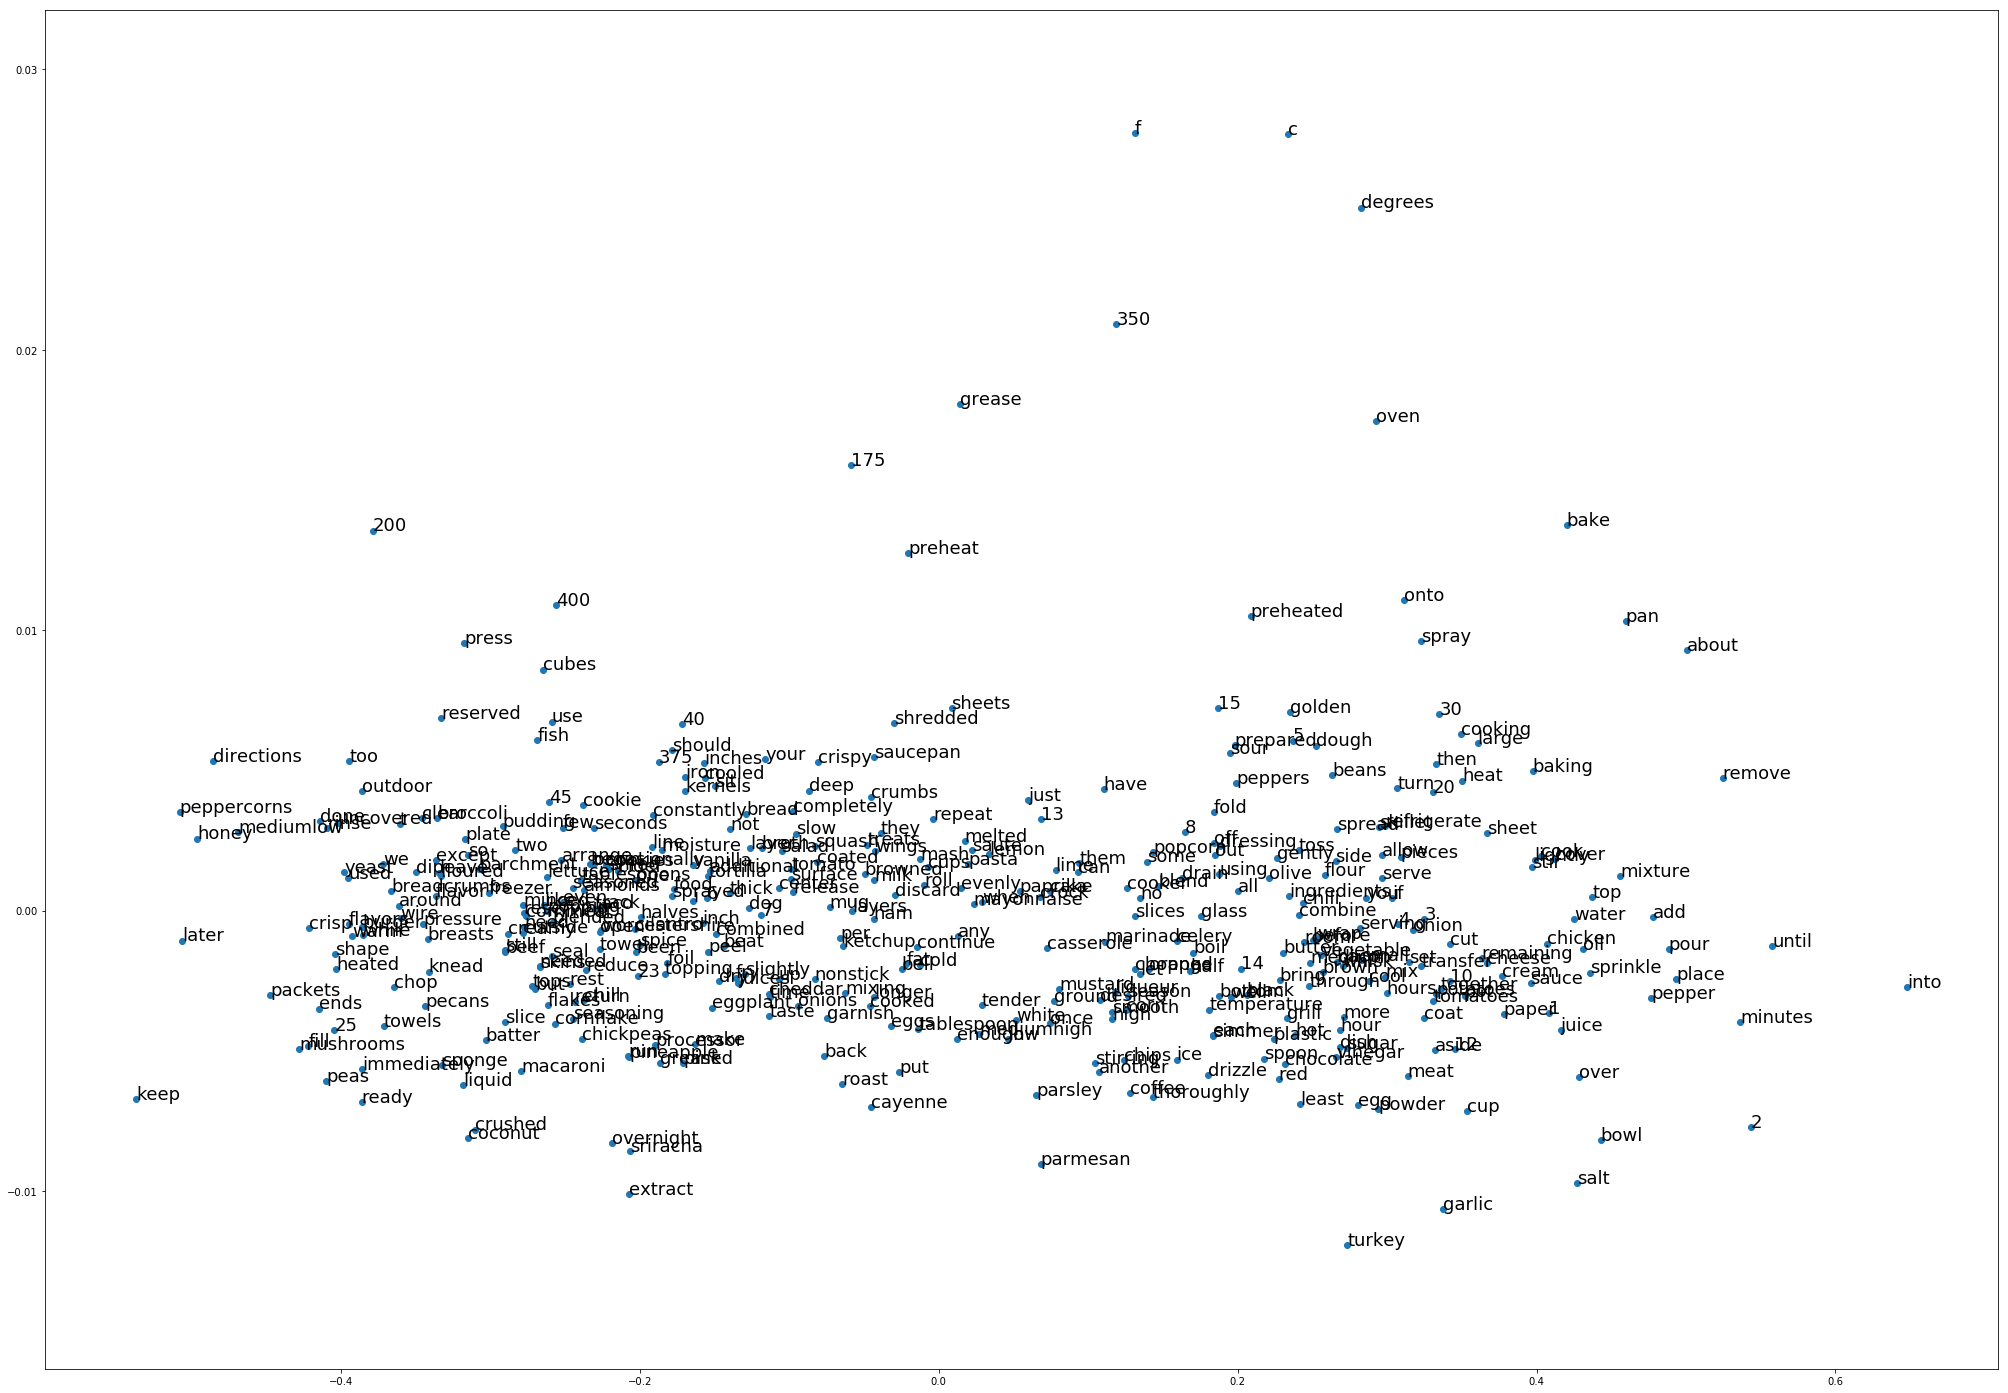

In [40]:
# PLOT PCA ONLY
plt.figure(figsize=((35,25)))
plt.scatter(pca_data[:, 0], pca_data[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(pca_data[i, 0], pca_data[i, 1]), fontsize=18)


In [41]:
from sklearn import manifold

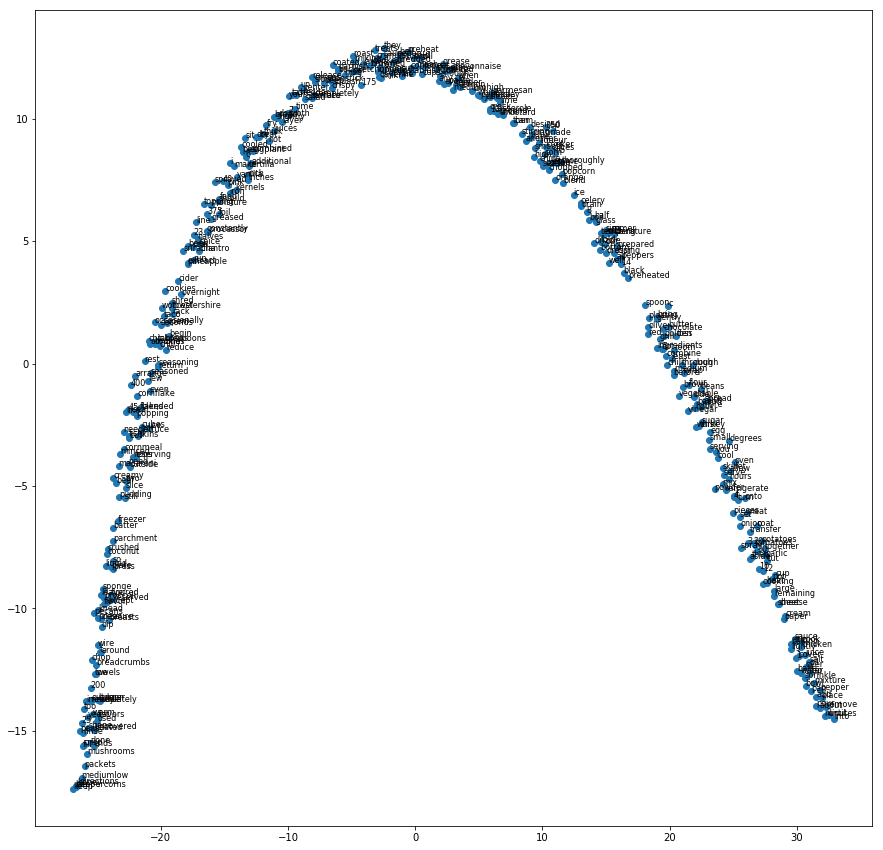

In [42]:
# PLOT TSNE ONLY
tsne = manifold.TSNE(n_components=2, init='pca', perplexity=30, random_state=0)
tsne_data = tsne.fit_transform(X)
plt.figure(figsize=((15,15)))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(tsne_data[i, 0], tsne_data[i, 1]), fontsize=8)


/anaconda/lib/python3.6/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


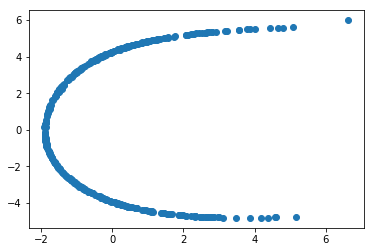

In [43]:
# PLOT MDS ONLY
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')

mds = manifold.MDS(2, max_iter=200, n_init=1)
distances = dist.pairwise(X)
mds_data = mds.fit_transform(distances)
plt.scatter(mds_data[:, 0], mds_data[:, 1])

In [44]:
# PLOT TSVD ONLY
from sklearn.decomposition import TruncatedSVD
t_svd = TruncatedSVD(n_components=2)

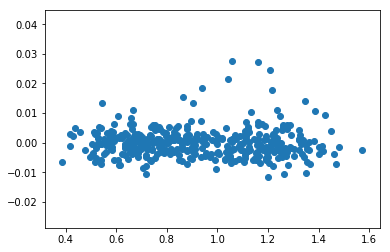

In [45]:
t_svd_data = t_svd.fit_transform(X)
plt.scatter(t_svd_data[:, 0], t_svd_data[:, 1])

# Clustering

In [46]:
# set up clustering estimators
from sklearn import cluster

dbscan = cluster.DBSCAN(metric='cityblock', algorithm='auto', min_samples=3, eps=.2) 
meanshift = cluster.MeanShift()
spectral = cluster.SpectralClustering()
affinity = cluster.AffinityPropagation(damping=.6, preference=.5)

## DBSCAN on MDS data

In [259]:
# dbscan with MDS data
mds_dbscan = dbscan.fit(mds_data)


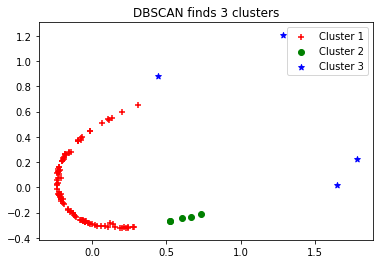

In [261]:
for i in range(0, mds_data.shape[0]):
    if mds_dbscan.labels_[i] == 0:
        c1 = plt.scatter(mds_data[i,0], mds_data[i,1], c='r', marker='+')
    elif mds_dbscan.labels_[i] == 1:
        c2 = plt.scatter(mds_data[i,0], mds_data[i,1], c='g', marker='o')
    elif mds_dbscan.labels_[i] == -1:
        c3 = plt.scatter(mds_data[i,0], mds_data[i,1], c='b', marker='*')
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3'])

plt.title('DBSCAN finds 3 clusters')
plt.show()

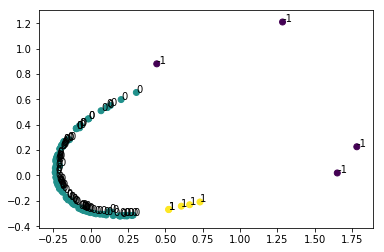

In [262]:
plt.scatter(mds_data[:, 0], mds_data[:,1], c = mds_dbscan.labels_)
words = list(mds_dbscan.labels_)
for i, word in enumerate(words):
    plt.annotate(word, xy=(mds_data[i, 0], mds_data[i, 1]), fontsize=10)


## DBSCAN on TSNE data

In [264]:
# lets see dbscan clusters for tsne
tsne_dbscan = dbscan.fit(tsne_data)

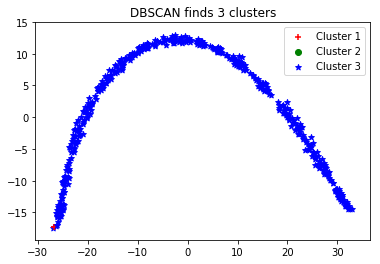

In [265]:
for i in range(0, tsne_data.shape[0]):
    if tsne_dbscan.labels_[i] == 0:
        c1 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='r', marker='+')
    elif tsne_dbscan.labels_[i] == 1:
        c2 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='g', marker='o')
    elif tsne_dbscan.labels_[i] == -1:
        c3 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='b', marker='*')
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('DBSCAN finds 3 clusters')
plt.show()

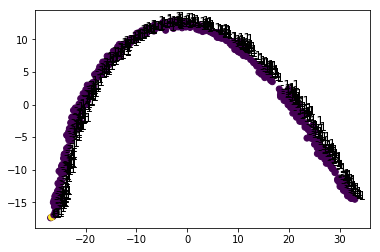

In [268]:
plt.scatter(tsne_data[:, 0], tsne_data[:,1], c = tsne_dbscan.labels_)
words = list(tsne_dbscan.labels_)
for i, word in enumerate(words):
    plt.annotate(word, xy=(tsne_data[i, 0], tsne_data[i, 1]), fontsize=12)


In [269]:
tsne_dbscan.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

## DBSCAN on PCA data

In [270]:
# dbscan with PCA data
pca_dbscan = dbscan.fit(pca_data)


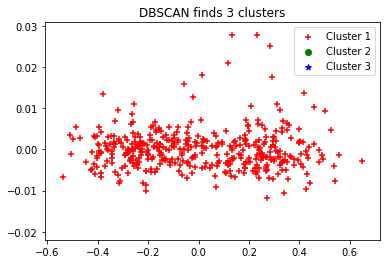

In [58]:
for i in range(0, pca_data.shape[0]):
    if pca_dbscan.labels_[i] == 0:
        c1 = plt.scatter(pca_data[i,0], pca_data[i,1], c='r', marker='+')
    elif pca_dbscan.labels_[i] == 1:
        c2 = plt.scatter(pca_data[i,0], pca_data[i,1], c='g', marker='o')
    elif pca_dbscan.labels_[i] == -1:
        c3 = plt.scatter(pca_data[i,0], pca_data[i,1], c='b', marker='*')
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('DBSCAN finds 3 clusters')
plt.show()

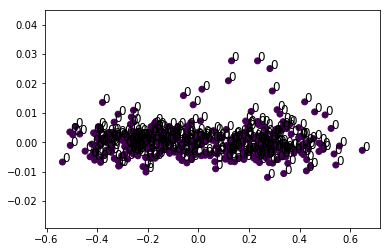

In [271]:
plt.scatter(pca_data[:, 0], pca_data[:,1], c = pca_dbscan.labels_)
words = list(pca_dbscan.labels_)
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_data[i, 0], pca_data[i, 1]), fontsize=12)


## DBSCAN on TruncatedSVD

In [272]:
tsvd_dbscan = dbscan.fit(t_svd_data)

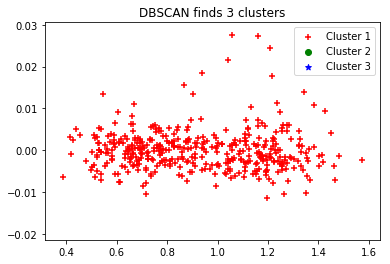

In [273]:
for i in range(0, t_svd_data.shape[0]):
    if tsvd_dbscan.labels_[i] == 0:
        c1 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='r', marker='+')
    elif tsvd_dbscan.labels_[i] == 1:
        c2 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='g', marker='o')
    elif tsvd_dbscan.labels_[i] == -1:
        c3 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='b', marker='*')
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('DBSCAN finds 3 clusters')
plt.show()

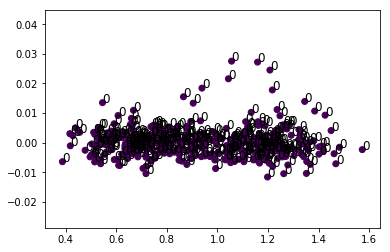

In [274]:
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_dbscan.labels_)
words = list(tsvd_dbscan.labels_)
for i, word in enumerate(words):
    plt.annotate(word, xy=(t_svd_data[i, 0], t_svd_data[i, 1]), fontsize=12)


## MeanShift on PCA data

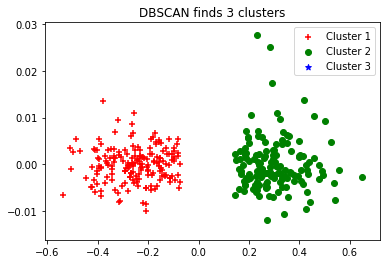

In [276]:
# Meanshift on PCA data
meanshift_pca = meanshift.fit(pca_data)
for i in range(0, pca_data.shape[0]):
    if meanshift_pca.labels_[i] == 0:
        c1 = plt.scatter(pca_data[i,0], pca_data[i,1], c='r', marker='+')
    elif meanshift_pca.labels_[i] == 1:
        c2 = plt.scatter(pca_data[i,0], pca_data[i,1], c='g', marker='o')
    elif meanshift_pca.labels_[i] == -1:
        c3 = plt.scatter(pca_data[i,0], pca_data[i,1], c='b', marker='*')
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('DBSCAN finds 3 clusters')
plt.show()

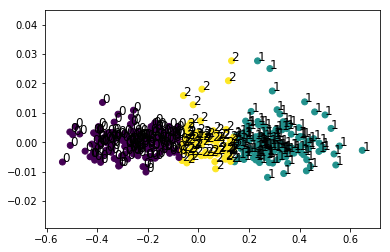

In [277]:
plt.scatter(pca_data[:, 0], pca_data[:,1], c = meanshift_pca.labels_)
words = list(meanshift_pca.labels_)
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_data[i, 0], pca_data[i, 1]), fontsize=12)


## MeanShift on MDS data

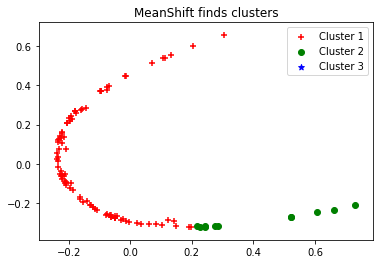

In [279]:
meanshift_mds = meanshift.fit(mds_data)
for i in range(0, mds_data.shape[0]):
    if meanshift_mds.labels_[i] == 0:
        c1 = plt.scatter(mds_data[i,0], mds_data[i,1], c='r', marker='+')
    elif meanshift_mds.labels_[i] == 1:
        c2 = plt.scatter(mds_data[i,0], mds_data[i,1], c='g', marker='o')
    elif meanshift_mds.labels_[i] == -1:
        c3 = plt.scatter(mds_data[i,0], mds_data[i,1], c='b', marker='*')
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('MeanShift finds clusters')
plt.show()

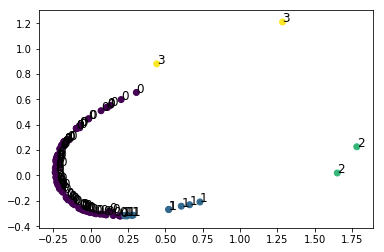

In [280]:
plt.scatter(mds_data[:, 0], mds_data[:,1], c = meanshift_mds.labels_)
words = list(meanshift_mds.labels_)
for i, word in enumerate(words):
    plt.annotate(word, xy=(mds_data[i, 0], mds_data[i, 1]), fontsize=12)


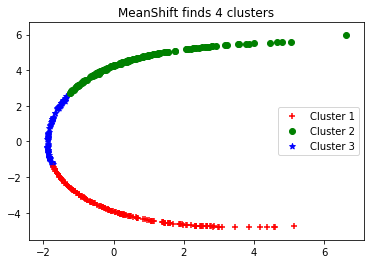

In [67]:
# meanshift mds
for i in range(0, mds_data.shape[0]):
    if meanshift_mds.labels_[i] == 0:
        c1 = plt.scatter(mds_data[i,0], mds_data[i,1], c='r', marker='+')
    elif meanshift_mds.labels_[i] == 1:
        c2 = plt.scatter(mds_data[i,0], mds_data[i,1], c='g', marker='o')
    elif meanshift_mds.labels_[i] == 2:
        c3 = plt.scatter(mds_data[i,0], mds_data[i,1], c='b', marker='*')
    elif meanshift_mds.labels_[i] == 3:
        c4 = plt.scatter(mds_data[i,0], mds_data[i,1], c='y', marker='^')

plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.title('MeanShift finds 4 clusters')
plt.show()

## MeanShift on TSNE data

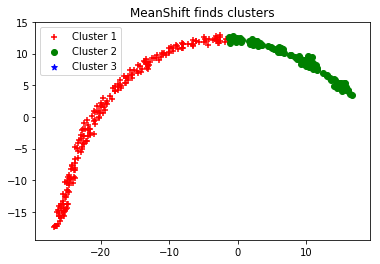

In [281]:
meanshift_tsne = meanshift.fit(tsne_data)
for i in range(0, pca_data.shape[0]):
    if meanshift_tsne.labels_[i] == 0:
        c1 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='r', marker='+')
    elif meanshift_tsne.labels_[i] == 1:
        c2 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='g', marker='o')
    elif meanshift_tsne.labels_[i] == -1:
        c3 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='b', marker='*')
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('MeanShift finds clusters')
plt.show()

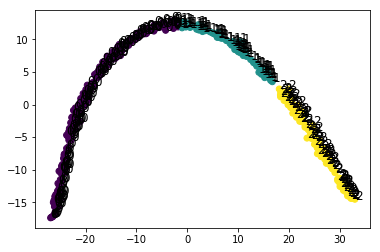

In [282]:
plt.scatter(tsne_data[:, 0], tsne_data[:,1], c = meanshift_tsne.labels_)
words = list(meanshift_tsne.labels_)
for i, word in enumerate(words):
    plt.annotate(word, xy=(tsne_data[i, 0], tsne_data[i, 1]), fontsize=12)


## MeanShift on PCA data

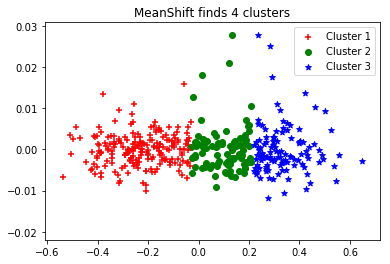

In [71]:
# meanshift pca
for i in range(0, pca_data.shape[0]):
    if meanshift_pca.labels_[i] == 0:
        c1 = plt.scatter(pca_data[i,0], pca_data[i,1], c='r', marker='+')
    elif meanshift_pca.labels_[i] == 1:
        c2 = plt.scatter(pca_data[i,0], pca_data[i,1], c='g', marker='o')
    elif meanshift_pca.labels_[i] == 2:
        c3 = plt.scatter(pca_data[i,0], pca_data[i,1], c='b', marker='*')
    elif meanshift_pca.labels_[i] == 3:
        c4 = plt.scatter(pca_data[i,0], pca_data[i,1], c='y', marker='^')

plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.title('MeanShift finds 4 clusters')
plt.show()

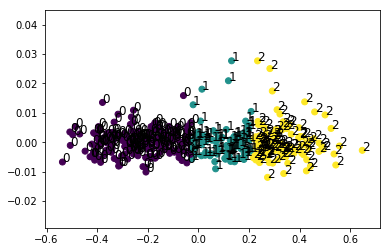

In [283]:
plt.scatter(pca_data[:, 0], pca_data[:,1], c = meanshift_pca.labels_)
words = list(meanshift_pca.labels_)
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_data[i, 0], pca_data[i, 1]), fontsize=12)


## MeanShift on TSVD

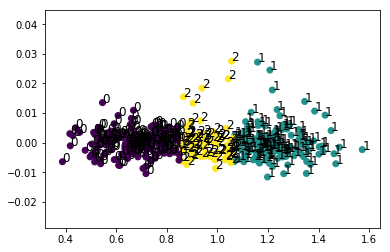

In [284]:
tsvd_meanshift = meanshift.fit(t_svd_data)
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_meanshift.labels_)
words = list(tsvd_meanshift.labels_)
for i, word in enumerate(words):
    plt.annotate(word, xy=(t_svd_data[i, 0], t_svd_data[i, 1]), fontsize=12)


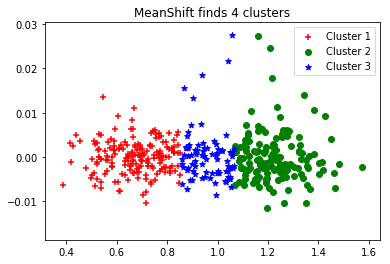

In [285]:
for i in range(0, t_svd_data.shape[0]):
    if tsvd_meanshift.labels_[i] == 0:
        c1 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='r', marker='+')
    elif tsvd_meanshift.labels_[i] == 1:
        c2 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='g', marker='o')
    elif tsvd_meanshift.labels_[i] == 2:
        c3 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='b', marker='*')
    elif tsvd_meanshift.labels_[i] == 3:
        c4 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='y', marker='^')

plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.title('MeanShift finds 4 clusters')
plt.show()

## Spectral Clustering 

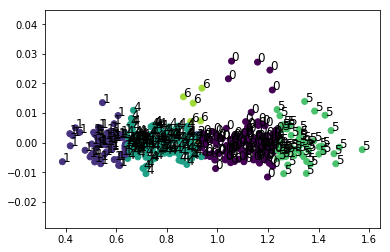

In [286]:
# truncated svd
tsvd_spectral = spectral.fit(t_svd_data)
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_spectral.labels_)
words = list(tsvd_spectral.labels_)
for i, word in enumerate(words):
    plt.annotate(word, xy=(t_svd_data[i, 0], t_svd_data[i, 1]), fontsize=12)


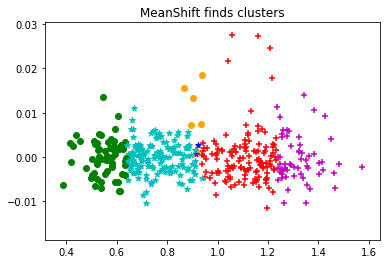

In [287]:
# truncated svd
for i in range(0, t_svd_data.shape[0]):
    if tsvd_spectral.labels_[i] == 0:
        c1 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='r', marker='+')
    elif tsvd_spectral.labels_[i] == 1:
        c2 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='g', marker='o')
    elif tsvd_spectral.labels_[i] == 2:
        c3 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='b', marker='*')
    elif tsvd_spectral.labels_[i] == 3:
        c4 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='y', marker='^')
    elif tsvd_spectral.labels_[i] == 4:
        c5 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='c', marker='*')
    elif tsvd_spectral.labels_[i] == 5:
        c6 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='m', marker='+')
    elif tsvd_spectral.labels_[i] == 6:
        c7 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='orange', marker='o')
    elif tsvd_spectral.labels_[i] == 7:
        c8 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='purple', marker='*')

plt.title('MeanShift finds clusters')
plt.show()

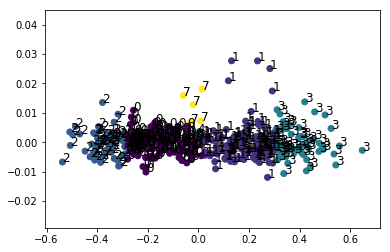

In [288]:
# PCA
spectral_pca = spectral.fit(pca_data)
plt.scatter(pca_data[:, 0], pca_data[:,1], c = spectral_pca.labels_)
words = list(spectral_pca.labels_)
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_data[i, 0], pca_data[i, 1]), fontsize=12)


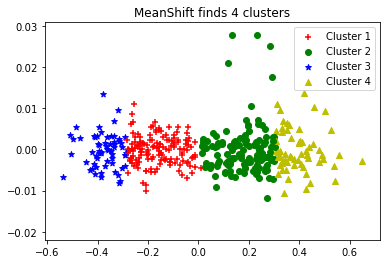

In [289]:
# PCA alt plot
# truncated svd
for i in range(0, pca_data.shape[0]):
    if spectral_pca.labels_[i] == 0:
        c1 = plt.scatter(pca_data[i,0], pca_data[i,1], c='r', marker='+')
    elif spectral_pca.labels_[i] == 1:
        c2 = plt.scatter(pca_data[i,0], pca_data[i,1], c='g', marker='o')
    elif spectral_pca.labels_[i] == 2:
        c3 = plt.scatter(pca_data[i,0], pca_data[i,1], c='b', marker='*')
    elif spectral_pca.labels_[i] == 3:
        c4 = plt.scatter(pca_data[i,0], pca_data[i,1], c='y', marker='^')

plt.legend([c1, c2, c3, c4], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.title('MeanShift finds 4 clusters')
plt.show()

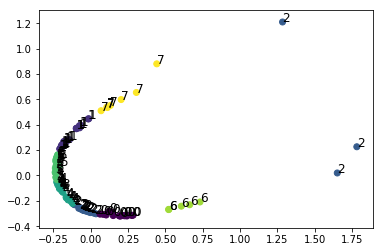

In [290]:
#MDS
spectral_mds = spectral.fit(mds_data)
plt.scatter(mds_data[:, 0], mds_data[:,1], c = spectral_mds.labels_)
words = list(spectral_mds.labels_)
for i, word in enumerate(words):
    plt.annotate(word, xy=(mds_data[i, 0], mds_data[i, 1]), fontsize=12)


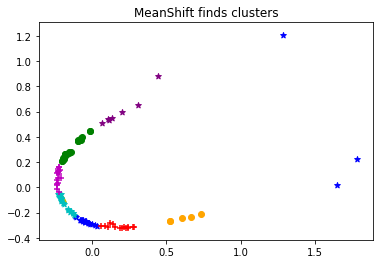

In [291]:
# MDS alt plot
# truncated svd
for i in range(0, mds_data.shape[0]):
    if spectral_mds.labels_[i] == 0:
        c1 = plt.scatter(mds_data[i,0], mds_data[i,1], c='r', marker='+')
    elif spectral_mds.labels_[i] == 1:
        c2 = plt.scatter(mds_data[i,0], mds_data[i,1], c='g', marker='o')
    elif spectral_mds.labels_[i] == 2:
        c3 = plt.scatter(mds_data[i,0], mds_data[i,1], c='b', marker='*')
    elif spectral_mds.labels_[i] == 3:
        c4 = plt.scatter(mds_data[i,0], mds_data[i,1], c='y', marker='^')
    elif spectral_mds.labels_[i] == 4:
        c5 = plt.scatter(mds_data[i,0], mds_data[i,1], c='c', marker='*')
    elif spectral_mds.labels_[i] == 5:
        c6 = plt.scatter(mds_data[i,0], mds_data[i,1], c='m', marker='+')
    elif spectral_mds.labels_[i] == 6:
        c7 = plt.scatter(mds_data[i,0], mds_data[i,1], c='orange', marker='o')
    elif spectral_mds.labels_[i] == 7:
        c8 = plt.scatter(mds_data[i,0], mds_data[i,1], c='purple', marker='*')

#plt.legend([c1, c2, c3, c4], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.title('MeanShift finds clusters')
plt.show()

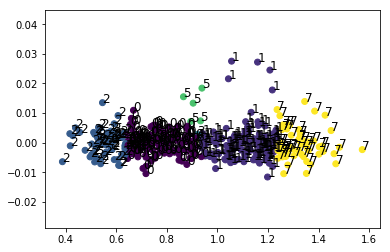

In [292]:
# tSNE
tsvd_spectral = spectral.fit(t_svd_data)
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_spectral.labels_)
words = list(tsvd_spectral.labels_)
for i, word in enumerate(words):
    plt.annotate(word, xy=(t_svd_data[i, 0], t_svd_data[i, 1]), fontsize=12)


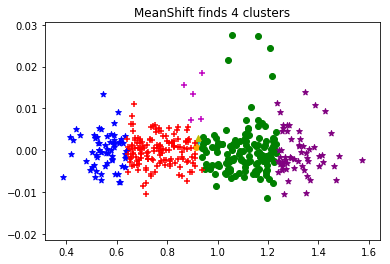

In [293]:
# tSNE alt plot
# truncated svd
for i in range(0, t_svd_data.shape[0]):
    if tsvd_spectral.labels_[i] == 0:
        c1 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='r', marker='+')
    elif tsvd_spectral.labels_[i] == 1:
        c2 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='g', marker='o')
    elif tsvd_spectral.labels_[i] == 2:
        c3 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='b', marker='*')
    elif tsvd_spectral.labels_[i] == 3:
        c4 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='y', marker='^')
    elif tsvd_spectral.labels_[i] == 4:
        c5 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='c', marker='*')
    elif tsvd_spectral.labels_[i] == 5:
        c6 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='m', marker='+')
    elif tsvd_spectral.labels_[i] == 6:
        c7 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='orange', marker='o')
    elif tsvd_spectral.labels_[i] == 7:
        c8 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='purple', marker='*')

plt.title('MeanShift finds 4 clusters')
plt.show()

## Affinity Propogation

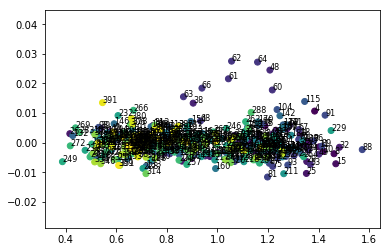

In [294]:
# t SVD
tsvd_affinity = affinity.fit(t_svd_data)
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_affinity.labels_)
words = list(tsvd_affinity.labels_)
for i, word in enumerate(words):
    plt.annotate(word, xy=(t_svd_data[i, 0], t_svd_data[i, 1]), fontsize=8)


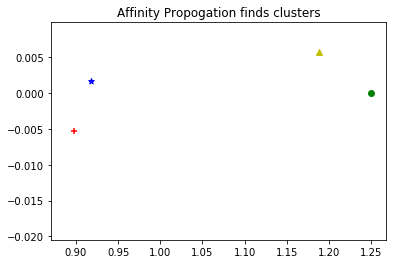

In [295]:
# tSVD
# truncated svd
for i in range(0, t_svd_data.shape[0]):
    if tsvd_affinity.labels_[i] == 0:
        c1 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='r', marker='+')
    elif tsvd_affinity.labels_[i] == 1:
        c2 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='g', marker='o')
    elif tsvd_affinity.labels_[i] == 2:
        c3 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='b', marker='*')
    elif tsvd_affinity.labels_[i] == 3:
        c4 = plt.scatter(t_svd_data[i,0], t_svd_data[i,1], c='y', marker='^')

plt.title('Affinity Propogation finds clusters')
plt.show()

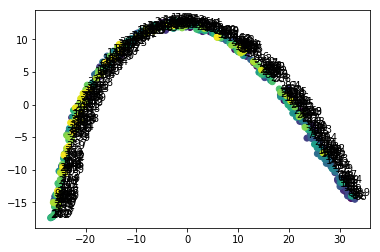

In [300]:
#tSNE
tsne_affinity = affinity.fit(tsne_data)
plt.scatter(tsne_data[:, 0], tsne_data[:,1], c = tsne_affinity.labels_)
words = list(tsne_affinity.labels_)
for i, word in enumerate(words):
    plt.annotate(word, xy=(tsne_data[i, 0], tsne_data[i, 1]), fontsize=10)


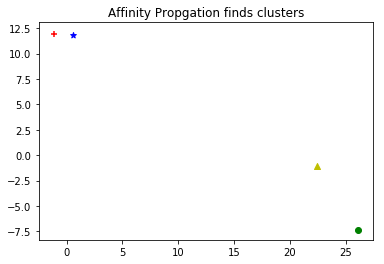

In [299]:
#tSNE
# truncated svd
for i in range(0, tsne_data.shape[0]):
    if tsne_affinity.labels_[i] == 0:
        c1 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='r', marker='+')
    elif tsne_affinity.labels_[i] == 1:
        c2 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='g', marker='o')
    elif tsne_affinity.labels_[i] == 2:
        c3 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='b', marker='*')
    elif tsne_affinity.labels_[i] == 3:
        c4 = plt.scatter(tsne_data[i,0], tsne_data[i,1], c='y', marker='^')

plt.title('Affinity Propgation finds clusters')
plt.show()

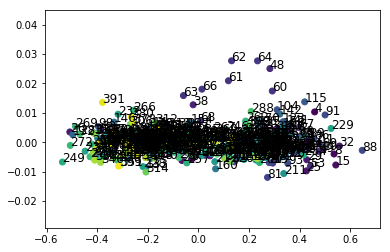

In [301]:
# PCA
affinity_pca = affinity.fit(pca_data)
plt.scatter(pca_data[:, 0], pca_data[:,1], c = affinity_pca.labels_)
words = list(affinity_pca.labels_)
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_data[i, 0], pca_data[i, 1]), fontsize=12)


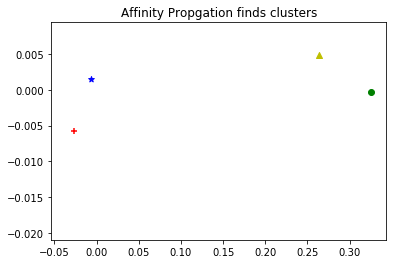

In [302]:
#PCA
# truncated svd
for i in range(0, pca_data.shape[0]):
    if affinity_pca.labels_[i] == 0:
        c1 = plt.scatter(pca_data[i,0], pca_data[i,1], c='r', marker='+')
    elif affinity_pca.labels_[i] == 1:
        c2 = plt.scatter(pca_data[i,0], pca_data[i,1], c='g', marker='o')
    elif affinity_pca.labels_[i] == 2:
        c3 = plt.scatter(pca_data[i,0], pca_data[i,1], c='b', marker='*')
    elif affinity_pca.labels_[i] == 3:
        c4 = plt.scatter(pca_data[i,0], pca_data[i,1], c='y', marker='^')

plt.title('Affinity Propgation finds clusters')
plt.show()

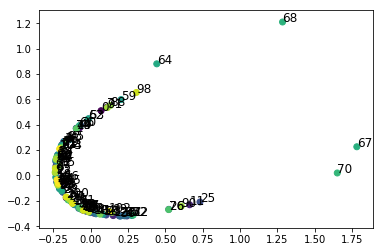

In [303]:
#MDS
affinity_mds = affinity.fit(mds_data)
plt.scatter(mds_data[:, 0], mds_data[:,1], c = affinity_mds.labels_)
words = list(affinity_mds.labels_)
for i, word in enumerate(words):
    plt.annotate(word, xy=(mds_data[i, 0], mds_data[i, 1]), fontsize=12)


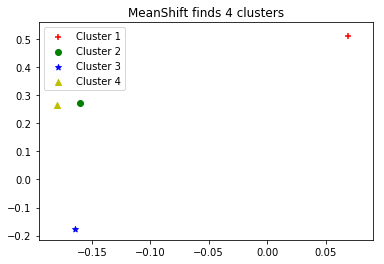

In [304]:
#MDS
# truncated svd
for i in range(0, mds_data.shape[0]):
    if affinity_mds.labels_[i] == 0:
        c1 = plt.scatter(mds_data[i,0], mds_data[i,1], c='r', marker='+')
    elif affinity_mds.labels_[i] == 1:
        c2 = plt.scatter(mds_data[i,0], mds_data[i,1], c='g', marker='o')
    elif affinity_mds.labels_[i] == 2:
        c3 = plt.scatter(mds_data[i,0], mds_data[i,1], c='b', marker='*')
    elif affinity_mds.labels_[i] == 3:
        c4 = plt.scatter(mds_data[i,0], mds_data[i,1], c='y', marker='^')

plt.legend([c1, c2, c3, c4], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.title('MeanShift finds 4 clusters')
plt.show()

# Supervised Learning

In [236]:
y = raw_recipe_data['Author_codes']
X_vectors = raw_recipe_data['Instruction_Vectors'].values

X_train, X_test, y_train, y_test = train_test_split(X_vectors, y, test_size=.25)

In [237]:
# reduce dimentionality
pca_X_vectors = pca.fit_transform(list(X_train))
tsne_X_vectors = tsne.fit_transform(list(X_train)) 
t_svd_X_vectors = t_svd.fit_transform(list(X_train))

X_vectors_distances = dist.pairwise(list(X_train))
mds_X_vectors = mds.fit_transform(X_vectors_distances)

/anaconda/lib/python3.6/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


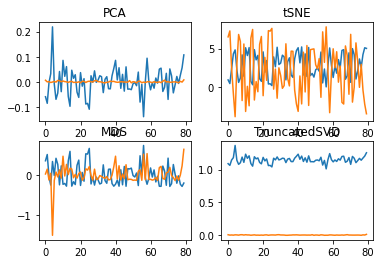

In [238]:
# subplots anyone
grid_size = (2,2)

plt.subplot2grid(grid_size, (0,0))
plt.plot(pca_X_vectors)
plt.title('PCA')
plt.subplot2grid(grid_size, (0,1))
plt.plot(tsne_X_vectors)
plt.title('tSNE')
plt.subplot2grid(grid_size, (1,1))
plt.plot(t_svd_X_vectors)
plt.title('TruncatedSVD')
plt.subplot2grid(grid_size, (1,0))
plt.plot(mds_X_vectors)
plt.title('MDS')

plt.show()

In [188]:
# lets see some confusion matrices

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [239]:
# predict with PCA data
dbscan_pred_pca = dbscan.fit_predict(pca_X_vectors)
meanshift_pred_pca = meanshift.fit_predict(pca_X_vectors)
spectral_pred_pca = spectral.fit_predict(pca_X_vectors)
affinity_pred_pca = affinity.fit_predict(pca_X_vectors)

In [240]:
from sklearn.metrics import confusion_matrix
import itertools

In [242]:
classes = y.unique()
dbscan_confusion_matrix = confusion_matrix(dbscan_pred_pca, y_train)
meanshift_confusion_matrix = confusion_matrix(meanshift_pred_pca, y_train)
spectral_confusion_matrix = confusion_matrix(spectral_pred_pca, y_train)
affinity_confusion_matrix = confusion_matrix(affinity_pred_pca, y_train)

Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization


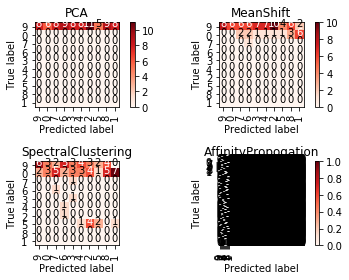

In [243]:
grid_size = (2,2)
plt.subplot2grid(grid_size, (0,0))
plot_confusion_matrix(dbscan_confusion_matrix, classes=classes)
plt.title('PCA')
plt.subplot2grid(grid_size, (0,1))
plot_confusion_matrix(meanshift_confusion_matrix, classes=classes)
plt.title('MeanShift')
plt.subplot2grid(grid_size, (1,0))
plot_confusion_matrix(spectral_confusion_matrix, classes=classes)
plt.title('SpectralClustering')
plt.subplot2grid(grid_size, (1,1))
plot_confusion_matrix(affinity_confusion_matrix, classes=classes)
plt.title('AffinityPropogation')

plt.show()

In [244]:
# predict with tSNE data
dbscan_pred_tsne = dbscan.fit_predict(tsne_X_vectors)
meanshift_pred_tsne = meanshift.fit_predict(tsne_X_vectors)
spectral_pred_tsne = spectral.fit_predict(tsne_X_vectors)
affinity_pred_tsne = affinity.fit_predict(tsne_X_vectors)

In [245]:
dbscan_cm_tsne = confusion_matrix(dbscan_pred_tsne, y_train)
meanshift_cm_tsne = confusion_matrix(meanshift_pred_tsne, y_train)
spectral_cm_tsne = confusion_matrix(spectral_pred_tsne, y_train)
affinity_cm_tsne = confusion_matrix(affinity_pred_tsne, y_train)

Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization


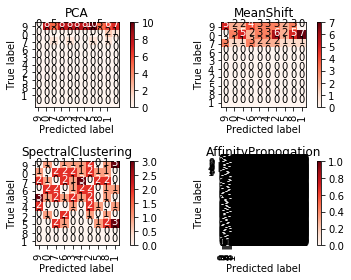

In [246]:
grid_size = (2,2)
plt.subplot2grid(grid_size, (0,0))
plot_confusion_matrix(dbscan_cm_tsne, classes=classes)
plt.title('PCA')
plt.subplot2grid(grid_size, (0,1))
plot_confusion_matrix(meanshift_cm_tsne, classes=classes)
plt.title('MeanShift')
plt.subplot2grid(grid_size, (1,0))
plot_confusion_matrix(spectral_cm_tsne, classes=classes)
plt.title('SpectralClustering')
plt.subplot2grid(grid_size, (1,1))
plot_confusion_matrix(affinity_cm_tsne, classes=classes)
plt.title('AffinityPropogation')

plt.show()

In [247]:
# predict with TruncatedSVD data
dbscan_pred_svd = dbscan.fit_predict(t_svd_X_vectors)
meanshift_pred_svd = meanshift.fit_predict(t_svd_X_vectors)
spectral_pred_svd = spectral.fit_predict(t_svd_X_vectors)
affinity_pred_svd = affinity.fit_predict(t_svd_X_vectors)

In [248]:
dbscan_cm_svd = confusion_matrix(dbscan_pred_svd, y_train)
meanshift_cm_svd = confusion_matrix(meanshift_pred_svd, y_train)
spectral_cm_svd = confusion_matrix(spectral_pred_svd, y_train)
affinity_cm_svd = confusion_matrix(affinity_pred_svd, y_train)

Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization


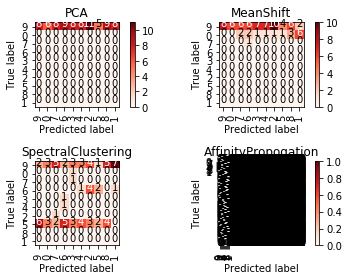

In [249]:
grid_size = (2,2)
plt.subplot2grid(grid_size, (0,0))
plot_confusion_matrix(dbscan_cm_svd, classes=classes)
plt.title('PCA')
plt.subplot2grid(grid_size, (0,1))
plot_confusion_matrix(meanshift_cm_svd, classes=classes)
plt.title('MeanShift')
plt.subplot2grid(grid_size, (1,0))
plot_confusion_matrix(spectral_cm_svd, classes=classes)
plt.title('SpectralClustering')
plt.subplot2grid(grid_size, (1,1))
plot_confusion_matrix(affinity_cm_svd, classes=classes)
plt.title('AffinityPropogation')

plt.show()

In [250]:
# predict with MDS data
dbscan_pred_mds = dbscan.fit_predict(mds_X_vectors)
meanshift_pred_mds = meanshift.fit_predict(mds_X_vectors)
spectral_pred_mds = spectral.fit_predict(mds_X_vectors)
affinity_pred_mds = affinity.fit_predict(mds_X_vectors)

In [251]:
dbscan_cm_mds = confusion_matrix(dbscan_pred_mds, y_train)
meanshift_cm_mds = confusion_matrix(meanshift_pred_mds, y_train)
spectral_cm_mds = confusion_matrix(spectral_pred_mds, y_train)
affinity_cm_mds = confusion_matrix(affinity_pred_mds, y_train)

Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization


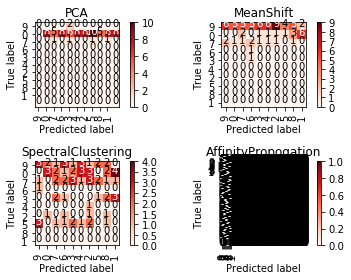

In [252]:
grid_size = (2,2)
plt.subplot2grid(grid_size, (0,0))
plot_confusion_matrix(dbscan_cm_mds, classes=classes)
plt.title('PCA')
plt.subplot2grid(grid_size, (0,1))
plot_confusion_matrix(meanshift_cm_mds, classes=classes)
plt.title('MeanShift')
plt.subplot2grid(grid_size, (1,0))
plot_confusion_matrix(spectral_cm_mds, classes=classes)
plt.title('SpectralClustering')
plt.subplot2grid(grid_size, (1,1))
plot_confusion_matrix(affinity_cm_mds, classes=classes)
plt.title('AffinityPropogation')

plt.show()